In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

%pip install pennylane
# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 39.0 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


In [3]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
quantum=True
batch_size = 4              # Number of samples for each training step
num_epochs = 3              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

Let us initialize a PennyLane device with the default simulator.


In [4]:
dev = qml.device('default.qubit', wires=n_qubits)


Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


**Dataset loading**

In [7]:
data_transforms = {
    "training": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "testing": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/drive/MyDrive/DR_dataset"
image_datasets = {
    x if x == "training" else "testing": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["training", "testing"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["training", "testing"]}
class_names = image_datasets["training"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["training", "testing"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [8]:
print(dataset_sizes)

{'training': 1040, 'testing': 260}


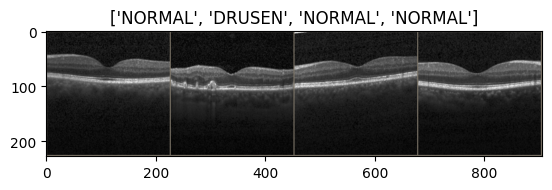

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["testing"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["training", "testing"]
}

In [10]:
print(classes)

tensor([1, 0, 1, 1])


Hybrid transfer learning model (classical-to-quantum).


In [11]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [12]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [13]:

class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [14]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.4MB/s]


Training and results


In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [17]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

In [18]:
correct_eval=[]
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and testing phase
        for phase in ["training", "testing"]:
            if phase == "training":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "training"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "training":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            correct_eval.append(epoch_acc)
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "training" if phase == "training" else "testing  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "testing" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "testing" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "training" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "training" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "training":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [19]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: training Epoch: 1/3 Loss: 0.6625 Acc: 0.6038        
Phase: testing   Epoch: 1/3 Loss: 0.5715 Acc: 0.7115        
Phase: training Epoch: 2/3 Loss: 0.5913 Acc: 0.6990        
Phase: testing   Epoch: 2/3 Loss: 0.4392 Acc: 0.8500        
Phase: training Epoch: 3/3 Loss: 0.5594 Acc: 0.7163        
Phase: testing   Epoch: 3/3 Loss: 0.3872 Acc: 0.8615        
Training completed in 17m 54s
Best test loss: 0.3872 | Best test accuracy: 0.8615


In [27]:
if quantum:
        torch.save(model_hybrid.state_dict(), "quantum_oct.pt")
        torch.save(model_hybrid.state_dict(), '/content/drive/My Drive/quantum_model.pth')
else:
        torch.save(model_hybrid.state_dict(), "classical_oct.pt")
        torch.save(model_hybrid.state_dict(), '/content/drive/My Drive/classical_model.pth')
print("Model state_dict saved.")

Model state_dict saved.


Load model from file

In [21]:
if quantum:
    model_hybrid.load_state_dict(torch.load("/content/drive/My Drive/quantum_model_T4.pth"))
else:
    model_hybrid.load_state_dict(torch.load("classical_oct.pt"))

Visualize the model

In [28]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['testing'] // batch_size
it = 0
eval_losses=[]
eval_accu=[]

# Testing loop
for inputs, labels in dataloaders['testing']:
    model_hybrid.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).detach().cpu().numpy()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it + 1, n_batches + 1, end='\r',flush=True))
    # print(f"Input variable: Number of samples = {len(labels)}")
    it+=1
    if(it+1==57):
      break
# Print final results
epoch_loss = running_loss / dataset_sizes['testing']
epoch_acc = running_corrects / dataset_sizes['testing']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))

Iter: 1/66
Iter: 2/66
Iter: 3/66
Iter: 4/66
Iter: 5/66
Iter: 6/66
Iter: 7/66
Iter: 8/66
Iter: 9/66
Iter: 10/66
Iter: 11/66
Iter: 12/66
Iter: 13/66
Iter: 14/66
Iter: 15/66
Iter: 16/66
Iter: 17/66
Iter: 18/66
Iter: 19/66
Iter: 20/66
Iter: 21/66
Iter: 22/66
Iter: 23/66
Iter: 24/66
Iter: 25/66
Iter: 26/66
Iter: 27/66
Iter: 28/66
Iter: 29/66
Iter: 30/66
Iter: 31/66
Iter: 32/66
Iter: 33/66
Iter: 34/66
Iter: 35/66
Iter: 36/66
Iter: 37/66
Iter: 38/66
Iter: 39/66
Iter: 40/66
Iter: 41/66
Iter: 42/66
Iter: 43/66
Iter: 44/66
Iter: 45/66
Iter: 46/66
Iter: 47/66
Iter: 48/66
Iter: 49/66
Iter: 50/66
Iter: 51/66
Iter: 52/66
Iter: 53/66
Iter: 54/66
Iter: 55/66
Iter: 56/66

Test Loss: 0.3229 Test Acc: 0.7462        


<class 'torch.Tensor'>
<class 'torch.Tensor'>


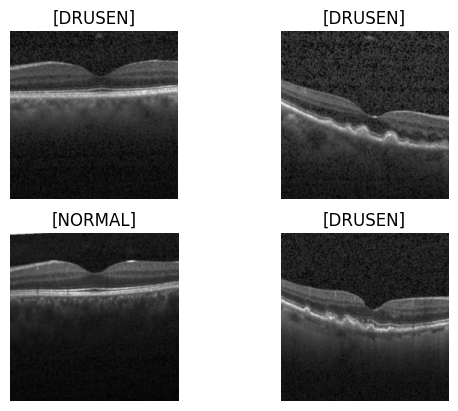

In [29]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            print(type(labels))
            outputs = model(inputs)
            _, preds1 = torch.max(outputs, 1)
            for j in range(inputs.size()[1]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

visualize_model(model_hybrid, num_images=batch_size)

Drawint the quntum circuit

In [30]:
drawer = qml.draw(quantum_net)
q_in_example = np.random.rand(n_qubits)
q_weights_flat = np.random.rand(6 * n_qubits)
print(drawer(q_in_example, q_weights_flat))

0: ──H──RY(0.59)─╭●──RY(0.07)───────────╭●──RY(0.30)───────────╭●──RY(0.12)───────────╭●──RY(0.26)
1: ──H──RY(0.05)─╰X─╭●─────────RY(0.95)─╰X─╭●─────────RY(0.10)─╰X─╭●─────────RY(0.50)─╰X─╭●───────
2: ──H──RY(0.61)─╭●─╰X─────────RY(0.97)─╭●─╰X─────────RY(0.68)─╭●─╰X─────────RY(0.03)─╭●─╰X───────
3: ──H──RY(0.17)─╰X──RY(0.81)───────────╰X──RY(0.44)───────────╰X──RY(0.91)───────────╰X──RY(0.52)

────────────╭●──RY(0.55)───────────╭●──RY(0.94)───────────┤  <Z>
───RY(0.66)─╰X─╭●─────────RY(0.18)─╰X─╭●─────────RY(0.89)─┤  <Z>
───RY(0.31)─╭●─╰X─────────RY(0.97)─╭●─╰X─────────RY(0.60)─┤  <Z>
────────────╰X──RY(0.78)───────────╰X──RY(0.92)───────────┤  <Z>


Classification report

In [31]:
from sklearn.metrics import classification_report

In [32]:
target_names = ['DRUSEN', 'NORMAL']
classes=classes.cpu()
preds=preds.cpu()
print(classification_report(classes, preds, target_names=target_names))

              precision    recall  f1-score   support

      DRUSEN       0.50      1.00      0.67         1
      NORMAL       1.00      0.67      0.80         3

    accuracy                           0.75         4
   macro avg       0.75      0.83      0.73         4
weighted avg       0.88      0.75      0.77         4

